# 2. Correlaciones, tratamiento de missing y outliers:

### Importo librerías:

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
from sklearn.impute import KNNImputer
import scipy.stats as ss

from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 5000)

### Funciones:

In [18]:
import funciones_auxiliares as f_aux

In [19]:
def cramers_v(confusion_matrix):
    """ 
    calculate Cramers V statistic for categorical-categorical association.
    uses correction from Bergsma and Wicher,
    Journal of the Korean Statistical Society 42 (2013): 323-328
    
    confusion_matrix tabla creada con pd.crosstab()
    
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

### Lectura de datos del preprocesado inicial:

In [20]:
# Lectura de datos:
df_fraud = pd.read_csv("../data/df_data_initial_preprocessing.csv").drop("Unnamed: 0", axis = 1)

df_fraud.shape

(1000000, 32)

In [21]:
# Visualización de conjunto de datos:
df_fraud.head()

,intended_balcon_amount,prev_address_months_count,bank_months_count,current_address_months_count,session_length_in_minutes,device_distinct_emails_8w,fraud_bool,foreign_request,phone_mobile_valid,has_other_cards,proposed_credit_limit,device_os,source,housing_status,keep_alive_session,device_fraud_count,phone_home_valid,credit_risk_score,email_is_free,income,employment_status,date_of_birth_distinct_emails_4w,bank_branch_count_8w,velocity_4w,velocity_24h,velocity_6h,zip_count_4w,payment_type,days_since_request,customer_age,name_email_similarity,month
0,NaN,NaN,24.0,88.0,3.888115,1.0,1,0.0,0.0,0.0,500.0,windows,INTERNET,BA,0.0,0.0,1.0,185.0,0.0,0.9,CA,6.0,1.0,3863.647740,3134.319630,10650.765523,769.0,AA,0.020925,50.0,0.166828,7.0
1,NaN,NaN,15.0,144.0,31.798819,1.0,1,0.0,0.0,0.0,1500.0,windows,INTERNET,BA,0.0,0.0,0.0,259.0,1.0,0.9,CA,3.0,718.0,3124.298166,2670.918292,534.047319,366.0,AB,0.005418,50.0,0.296286,7.0
2,NaN,NaN,NaN,132.0,4.728705,1.0,1,0.0,1.0,0.0,200.0,other,INTERNET,BA,0.0,0.0,0.0,177.0,1.0,0.9,CB,14.0,1.0,3159.590679,2893.621498,4048.534263,870.0,AC,3.108549,40.0,0.044985,7.0
3,NaN,NaN,31.0,22.0,2.047904,1.0,1,0.0,1.0,1.0,200.0,linux,INTERNET,BA,0.0,0.0,0.0,110.0,1.0,0.9,CA,6.0,1921.0,3022.261812,4054.908412,3457.064063,810.0,AB,0.019079,50.0,0.159511,7.0
4,NaN,NaN,31.0,218.0,3.775225,1.0,1,0.0,0.0,0.0,1500.0,macintosh,INTERNET,BA,1.0,0.0,1.0,295.0,1.0,0.9,CA,2.0,1990.0,3087.670952,2728.237159,5020.341679,890.0,AB,0.004441,50.0,0.596414,7.0


In [22]:
# Visualización del nombre de las variables del conjunto de datos:
df_fraud.columns

Index(['intended_balcon_amount', 'prev_address_months_count',
       'bank_months_count', 'current_address_months_count',
       'session_length_in_minutes', 'device_distinct_emails_8w', 'fraud_bool',
       'foreign_request', 'phone_mobile_valid', 'has_other_cards',
       'proposed_credit_limit', 'device_os', 'source', 'housing_status',
       'keep_alive_session', 'device_fraud_count', 'phone_home_valid',
       'credit_risk_score', 'email_is_free', 'income', 'employment_status',
       'date_of_birth_distinct_emails_4w', 'bank_branch_count_8w',
       'velocity_4w', 'velocity_24h', 'velocity_6h', 'zip_count_4w',
       'payment_type', 'days_since_request', 'customer_age',
       'name_email_similarity', 'month'],
      dtype='object')

In [23]:
# Visualización de los tipos de las columans del conjunto de datos:
categoricals_list, other = f_aux.dame_variables_categoricas(dataset = df_fraud)
df_fraud[categoricals_list] = df_fraud[categoricals_list].astype("category")
continuous_list = list(df_fraud.select_dtypes("float").columns)
df_fraud[continuous_list] = df_fraud[continuous_list].astype(float)
df_fraud.dtypes #aquí estamos comprobando en todas las columnas de qué tipo son

intended_balcon_amount               float64
prev_address_months_count            float64
bank_months_count                    float64
current_address_months_count         float64
session_length_in_minutes            float64
device_distinct_emails_8w            float64
fraud_bool                          category
foreign_request                      float64
phone_mobile_valid                   float64
has_other_cards                      float64
proposed_credit_limit                float64
device_os                           category
source                              category
housing_status                      category
keep_alive_session                   float64
device_fraud_count                   float64
phone_home_valid                     float64
credit_risk_score                    float64
email_is_free                        float64
income                               float64
employment_status                   category
date_of_birth_distinct_emails_4w     float64
bank_branc

### Separación en train y test estratificado:

In [24]:
# Separación de train y test:
x_df_fraud, x_df_fraud_test, y_df_fraud, y_df_fraud_test = train_test_split(
                                                                    df_fraud.drop("fraud_bool",axis=1), 
                                                                    df_fraud["fraud_bool"], 
                                                                    stratify = df_fraud["fraud_bool"], 
                                                                    test_size = 0.2)

# Creando dataframes de train y test y visualizando el dataframe de test:
df_fraud_train = pd.concat([x_df_fraud, y_df_fraud], axis = 1)
df_fraud_test = pd.concat([x_df_fraud_test, y_df_fraud_test], axis = 1)
df_fraud_test

,intended_balcon_amount,prev_address_months_count,bank_months_count,current_address_months_count,session_length_in_minutes,device_distinct_emails_8w,foreign_request,phone_mobile_valid,has_other_cards,proposed_credit_limit,device_os,source,housing_status,keep_alive_session,device_fraud_count,phone_home_valid,credit_risk_score,email_is_free,income,employment_status,date_of_birth_distinct_emails_4w,bank_branch_count_8w,velocity_4w,velocity_24h,velocity_6h,zip_count_4w,payment_type,days_since_request,customer_age,name_email_similarity,month,fraud_bool
562868,NaN,NaN,NaN,110.0,1.610522,1.0,0.0,1.0,0.0,200.0,other,INTERNET,BE,0.0,0.0,1.0,139.0,0.0,0.3,CA,9.0,0.0,3773.403348,2972.333996,1989.494844,1016.0,AC,0.024168,10.0,0.213884,6.0,0
151944,NaN,NaN,10.0,57.0,2.829008,1.0,0.0,0.0,0.0,1500.0,windows,INTERNET,BC,0.0,0.0,0.0,212.0,1.0,0.9,CB,12.0,26.0,5275.236168,3764.833428,2758.216693,756.0,AB,0.012526,40.0,0.142021,3.0,0
206370,NaN,NaN,1.0,141.0,4.810681,1.0,0.0,1.0,0.0,200.0,macintosh,INTERNET,BC,1.0,0.0,0.0,74.0,1.0,0.9,CA,9.0,12.0,4679.983493,6105.984776,8869.100047,954.0,AD,0.017159,40.0,0.821449,3.0,0
224008,NaN,NaN,15.0,129.0,1.273628,1.0,0.0,0.0,1.0,200.0,windows,INTERNET,BB,0.0,0.0,1.0,169.0,1.0,0.1,CA,2.0,52.0,4914.998343,5701.472840,8030.691331,1182.0,AB,0.026018,50.0,0.884538,3.0,0
693591,NaN,NaN,1.0,148.0,2.817269,1.0,0.0,0.0,0.0,200.0,windows,INTERNET,BB,1.0,0.0,1.0,34.0,0.0,0.4,CA,7.0,28.0,5935.404026,7120.591712,11172.819519,692.0,AB,0.008005,50.0,0.523464,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
963208,NaN,NaN,15.0,24.0,12.379178,1.0,0.0,0.0,0.0,200.0,windows,INTERNET,BC,1.0,0.0,1.0,103.0,1.0,0.7,CD,5.0,53.0,4240.520104,4951.668197,6590.259087,1399.0,AB,0.022739,50.0,0.273329,4.0,0
447255,14.836178,NaN,30.0,43.0,37.303256,1.0,0.0,1.0,0.0,200.0,other,INTERNET,BC,1.0,0.0,0.0,203.0,0.0,0.9,CB,2.0,38.0,4150.125200,5034.651022,10188.434579,746.0,AA,6.953621,50.0,0.880178,1.0,0
409929,NaN,NaN,NaN,93.0,12.253346,1.0,0.0,1.0,0.0,1500.0,windows,INTERNET,BB,1.0,0.0,0.0,240.0,1.0,0.9,CA,8.0,0.0,5494.766563,4653.034412,8283.149884,727.0,AC,0.008543,40.0,0.915426,1.0,0
881787,19.841594,NaN,10.0,69.0,11.156848,1.0,0.0,1.0,0.0,200.0,other,INTERNET,BB,0.0,0.0,1.0,50.0,0.0,0.9,CB,5.0,352.0,4424.208419,5201.482229,5750.369810,591.0,AA,14.092282,30.0,0.557906,4.0,0


In [25]:
# Comprobando que la proporción de instancias con fraude y sin fraude son similares en los dos dataframes:
print("", '== Train\n', df_fraud_train["fraud_bool"].value_counts(normalize = True))
print("""
""", '== Test\n', df_fraud_test["fraud_bool"].value_counts(normalize = True))

 == Train
 fraud_bool
0    0.988971
1    0.011029
Name: proportion, dtype: float64

 == Test
 fraud_bool
0    0.98897
1    0.01103
Name: proportion, dtype: float64


### Visualización descriptiva de los datos:

In [26]:
# Visualizando la proporción de instancias con fraude y sin fraude en el conjunto de datos que estamos analizando:
df_fraud_bool = df_fraud["fraud_bool"]\
    .value_counts(normalize = True)\
    .mul(100).rename("percent").reset_index()


df_fraud_bool_conteo = df_fraud["fraud_bool"].value_counts().reset_index()
df_fraud_bool_pc = pd.merge(df_fraud_bool, df_fraud_bool_conteo, on = "fraud_bool", how = 'inner')\
        .rename(columns = {"fraud_bool": "index"})


fig = px.histogram(df_fraud_bool_pc, x = "index", y = ['percent'])
fig.update_xaxes(tickvals = [0, 1])
fig.show()

En el gráfico de arriba podemos ver la proporción de instancias con fraude y sin fraude del conjunto de datos que estamos analizando. Se puede ver que el conjunto de datos esta muy sesgado, y que la gran mayoría de instancias no tienen fraude.
___________________________________________________________________________________________________________________________

En los gráficos de abajo podemos ver dos gráficos por cada variable. Para todas las variables categóricas, hemos ilustrado un gráfico de Countplot (diagrama de conteo) y un gráfico de Barplot (diagrama de barras). En cada diagrama de conteo ilustramos la cantidad de instancias de cada categoría de la variable. Por ejemplo, si vemos la variable categórica de "payment_type", podemos ver que alrededor de 200,000 instancias son de la categoría de "AA", mientras que casi 300,000 son de la categoría de "AB" y casi ninguna es de la categoría de "AE". Este gráfico nos ayuda a comprender la proporción de instancias que son parte de cada categoría. 

Por otro lado, cada diagrama de barras nos muestra la proporción de instancias que sean instancias con fraude o sin fraude para cada categoría de una variable específica. Por ejemplo, si vemos el diagrama de barras de la variable categórica de "housing_status", podemos ver que la gran mayoría de instancias de fraude son parte de la categoría de "BA". Este análisis en concreto es muy útil ya que al ver el diagrama de conteo de esta misma variable podemos ver que la categoría de "BA" solo tiene el cuarto mayor número de instancias de un total de siete categorías.

Por otra parte, para todas las variables numéricas, hemos ilustrado un gráfico de Histplot (un histograma) y un gráfico de Boxplot (diagrama de cajas). En cada histograma ilustramos la cantidad de instancias por cada valor de la variable (siendo, por lo tanto, un gráfico parecido a los diagramas de conteo de las variables categóricas). De esta manera, según el conjunto de datos, la mayoría de las instancias de gente aplicando han sido hechas desde códigos postales dónde también han habido alrededor de otras 1000 instancias de gente aplicando durante las cuatro semanas anteriores. Esto lo sabemos gracias a que el histograma de la variable numérica de "zip_count_4w" nos muestra que la mayoría de las instancias tienen un valor de alrededor de 1000 y que la variable representa el número de aplicaciones que se han registrado desde el mismo código postal durante las cuatro semanas anteriores a una aplicación. 

Cada diagrama de cajas de las variables numéricas nos enseña las características estadísticas de las instancias de fraude y no fraude dentro de la variable. Podemos ver la media (la linea negra en el medio de cada caja), los outliers (puntos negros fuera de las cajas), el primer cuartil (el limite derecho de cada caja) y el tercer cuartil de los datos (el limite izquierdo de cada caja). De esta manera, usando este gráfico, podemos fácilmente comparar las instancias de fraude y no fraude ya que el fraude esta colorado en naranja y el no fraude en azul. Podemos ver, por ejemplo, que en la variable de "income" como es mucho más probable que gente con sueldos más altos cometan fraude. Esto lo podemos ver ya que la media del sueldo de las instancias sin fraude es igual a el tercer cuartil de las instancias con fraude, y que la media de las instancias con fraude es igual a el primer cuartil de las instancias sin fraude.

Además, sobre cada gráfico de la izquierda también podemos ver la cantidad de valores nulos en la variable ya que tiene mucho que ver con las ilustraciones de los gráficos de conteo y los histogramas, sesgando los resultados cuando hay muchos valores nulos.

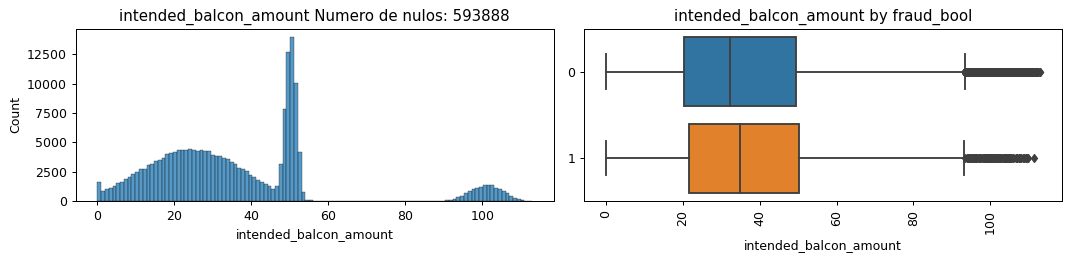

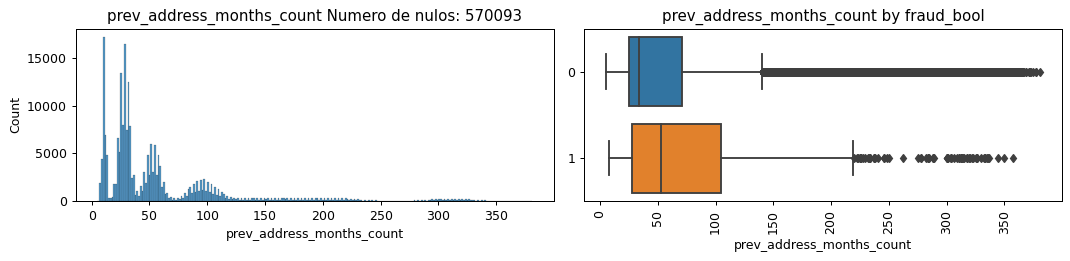

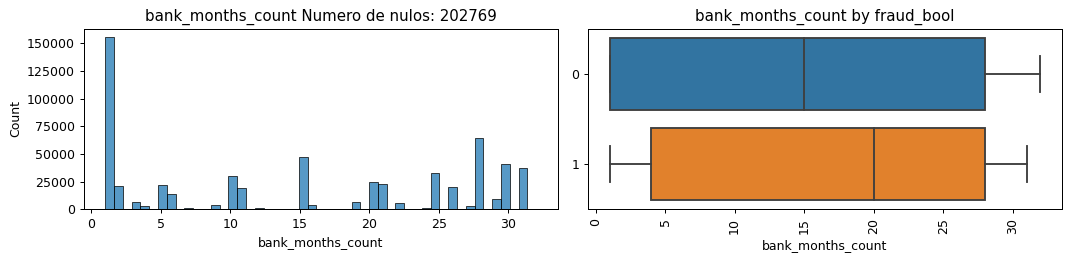

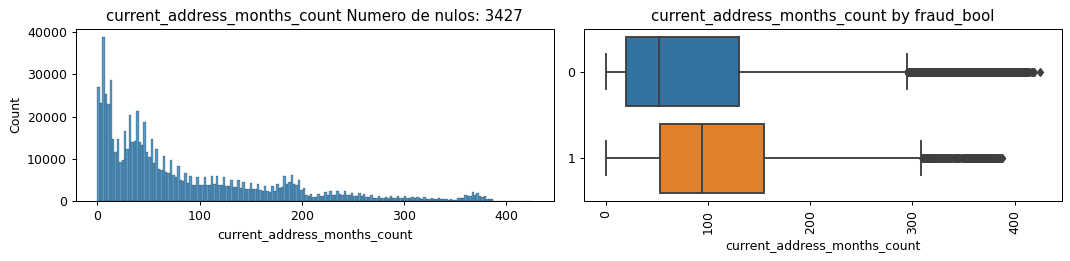

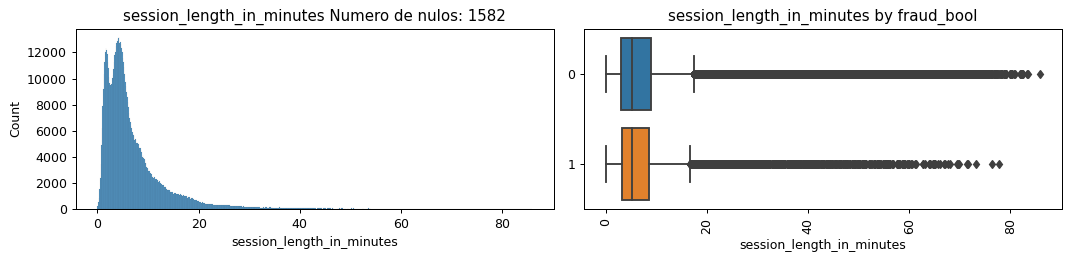

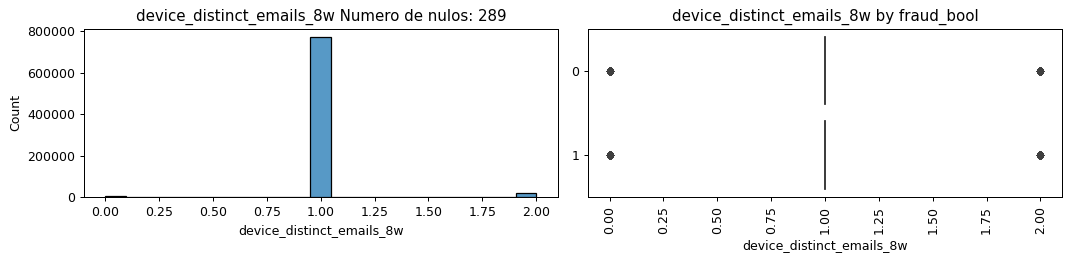

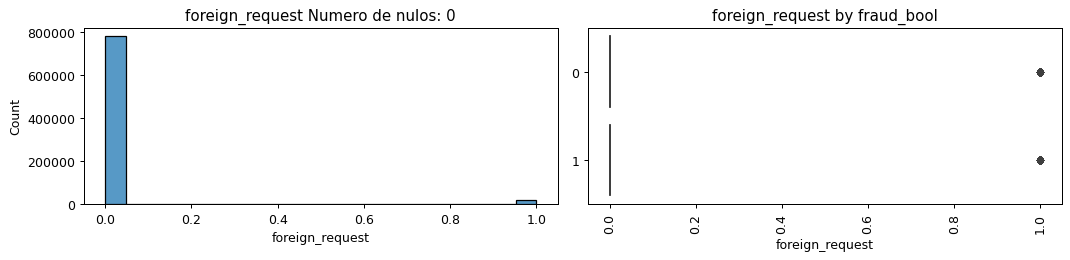

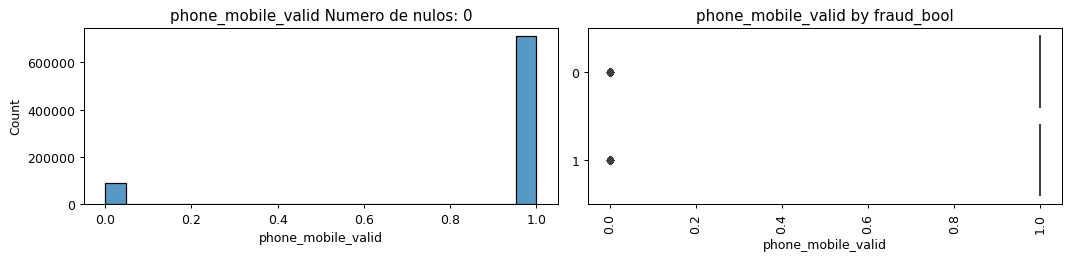

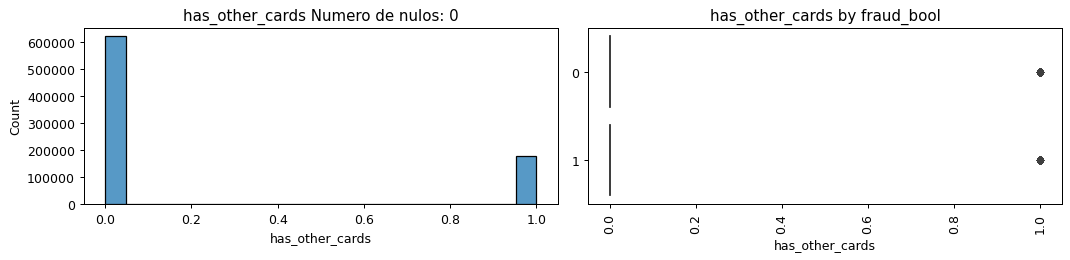

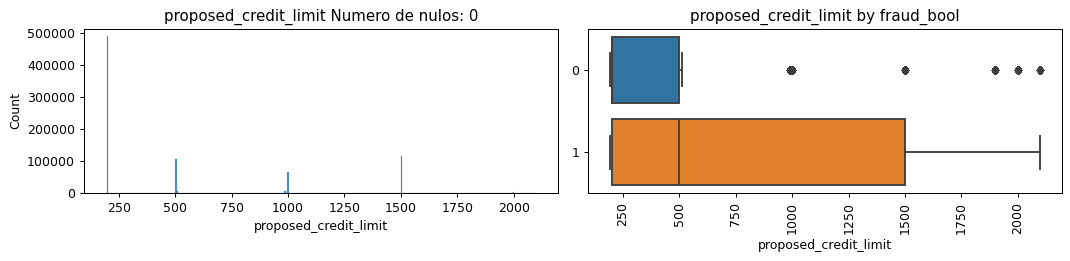

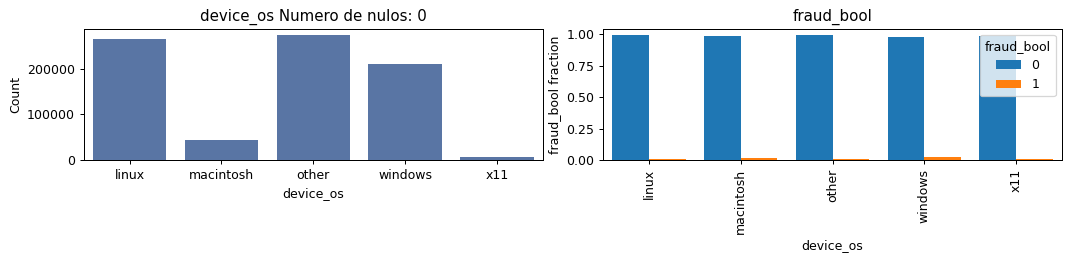

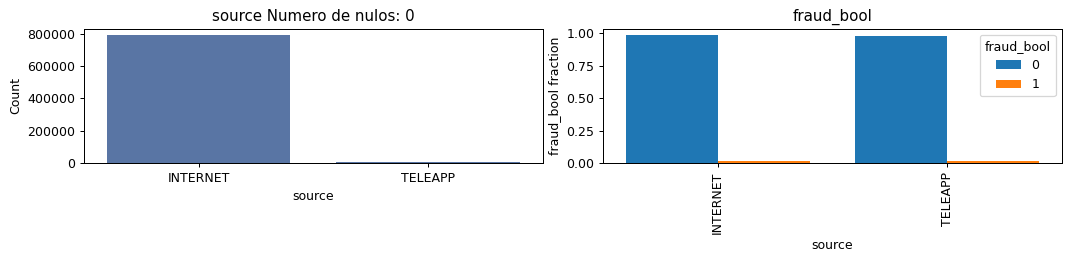

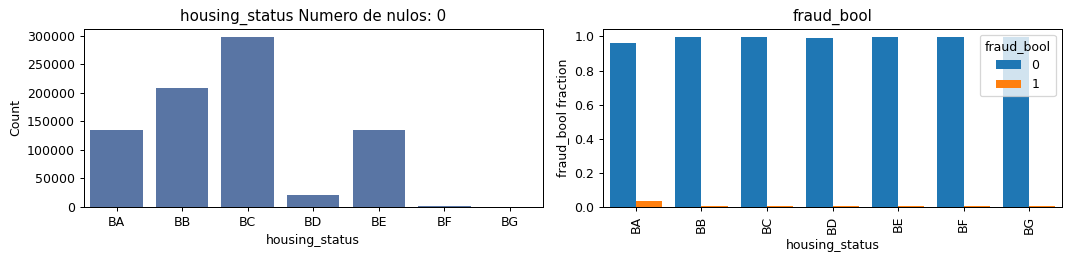

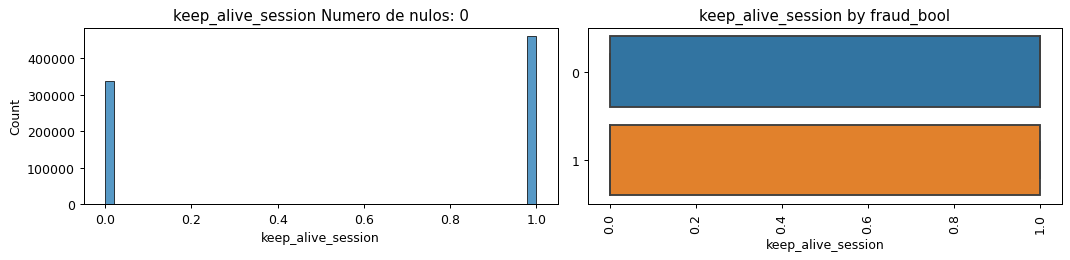

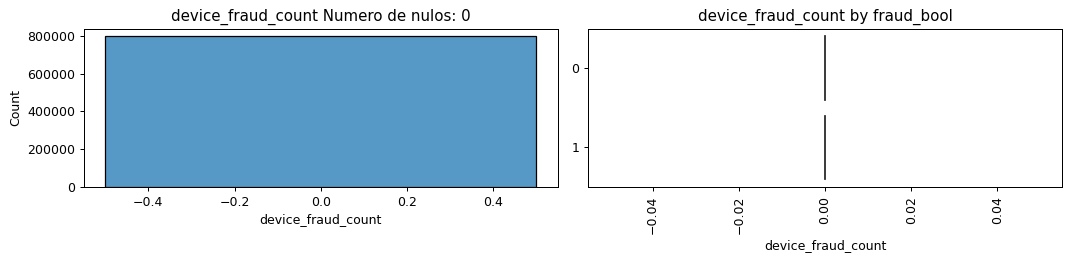

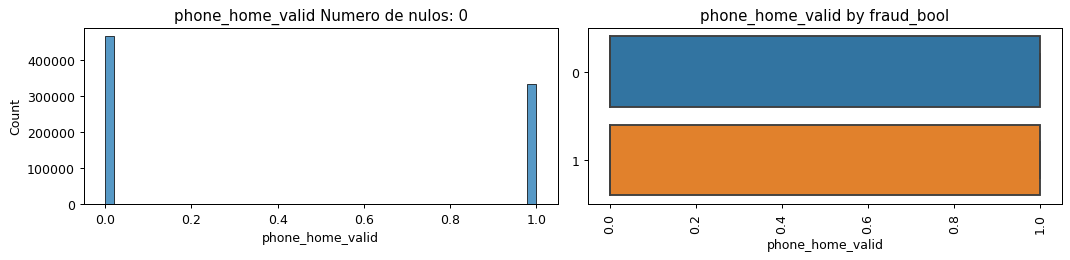

In [15]:
# Visualizando los datos y las características de las variables de una manera que también podamos comparar entre instancias
# con fraude y sin fraude y entre las variables en sí:
    # Hemos separado las 32 variables en dos grupos de 16 para que se tarde menos en cargar cada celda de código:
    
for i in list(df_fraud_train.columns[:16]):
    if (df_fraud_train[i].dtype == float) & (i != "fraud_bool"):
        f_aux.plot_feature(df_fraud_train, col_name = i, isContinuous = True, target = "fraud_bool")
    elif  i != "fraud_bool":
        f_aux.plot_feature(df_fraud_train, col_name = i, isContinuous = False, target = "fraud_bool")

Housing Status:
En el gráfico "housing status" podemos observar que BC es el valor más común. En el gráfico de barras de la derecha, BA suele ser el más utilizado para crear aplicaciones fraudulentas.

Source:
En el gráfico "source", internet es el medio más utilizado en general, superando a teleapp. Sin embargo, en el gráfico de la derecha, el nivel de fraude es similar desde teleapp e internet.

Device:
En el gráfico "device", Linux y otros (como Mac) son los más utilizados. En el gráfico de la derecha, Windows muestra una ligera ventaja en términos de fraudes.

Has Other Cards:
En el gráfico "has other cards", la mayoría no tiene otras tarjetas. En el gráfico de la derecha, la distribución es similar entre fraude y no fraude, con dos outliers en 1.

Proposed Credit Limit:
En el gráfico "proposed credit limit", las aplicaciones fraudulentas suelen tener un límite de crédito propuesto mayor, posiblemente para generar confianza.

Employment Status:
En el gráfico "employment status", CA, CC y CG son los valores más comunes y tienden a ser más utilizados para aplicaciones fraudulentas.

Bank Months Count:
En el gráfico "bank months count", se observa que los usuarios crean más cuentas fraudulentas después de llevar más de 17 meses.

Prev Adress Month Count:
En el gráfico "prev adress month count", el boxplot naranja indica que al menos el 50% de las aplicaciones fraudulentas no brindan esta información.

Foreign Request:
En el gráfico "foreign request", hay pocos casos con este valor, pero se observa que las cuentas con este valor tienden a utilizarse más para crear aplicaciones fraudulentas.

Keep Alive Session:
En el gráfico "keep alive session", la distribución es similar tanto para fraude como para no fraude.

Device Distinct Emails 8w:
En el gráfico "device distinct emails 8w", el valor 1 es el más repetido, indicando que las aplicaciones fraudulentas suelen provenir del mismo dispositivo.


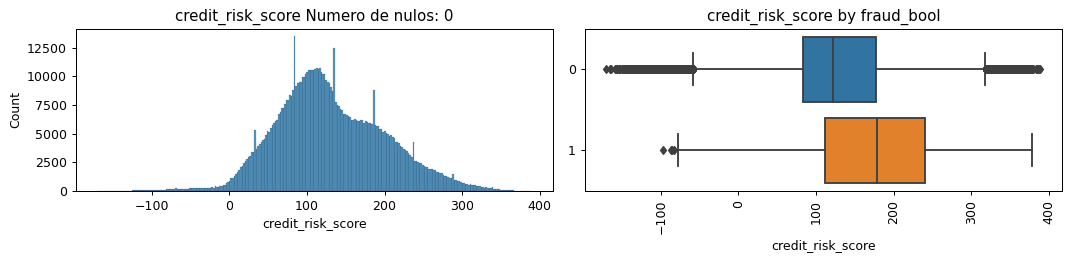

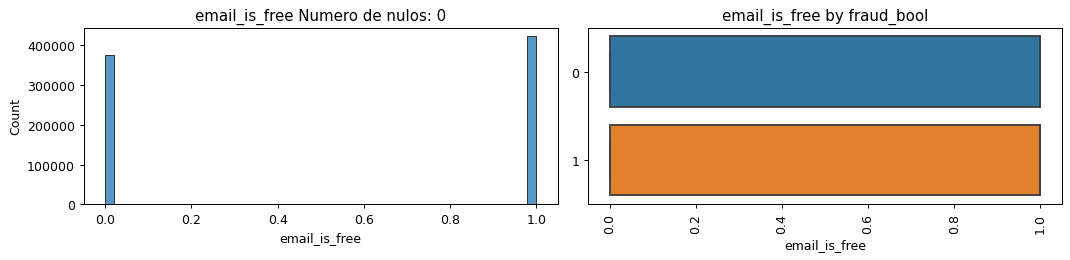

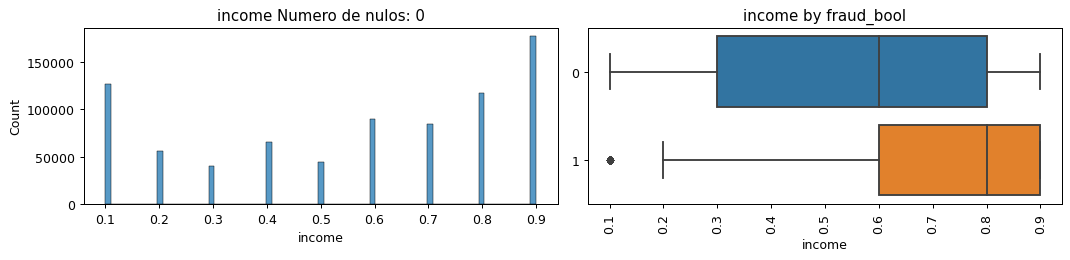

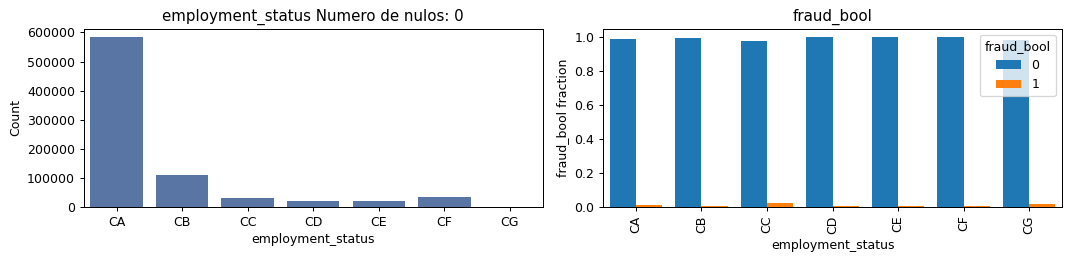

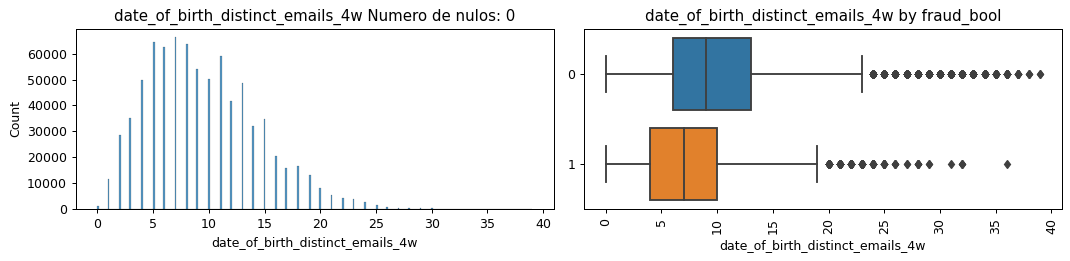

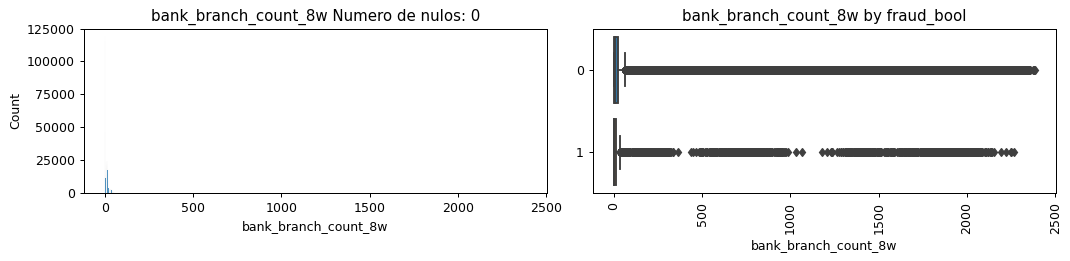

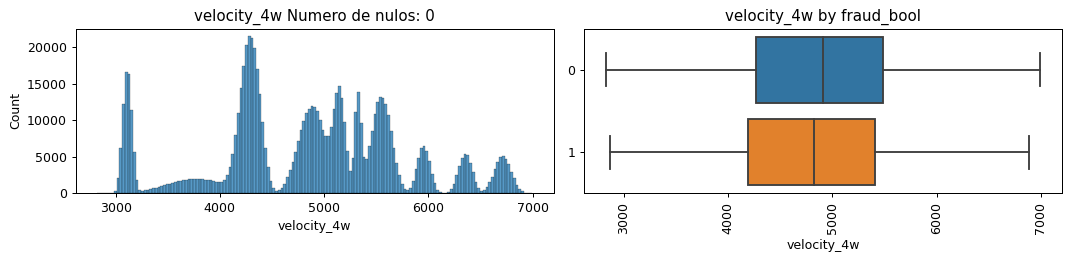

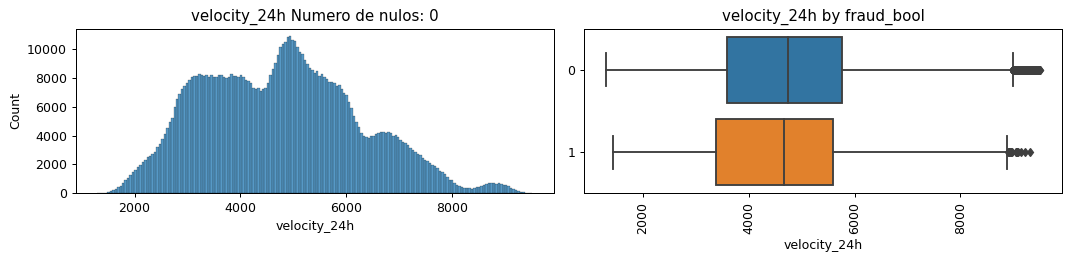

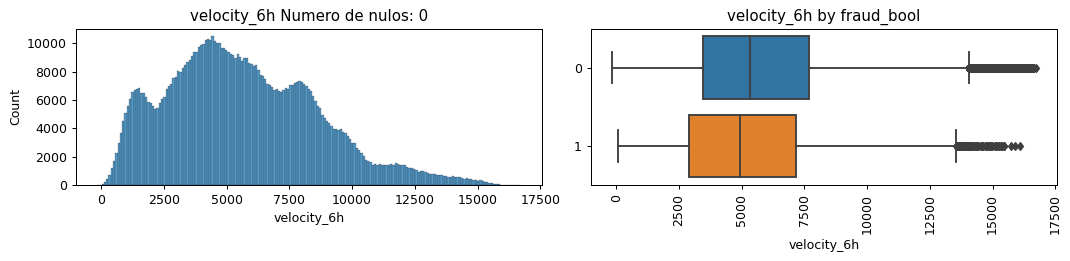

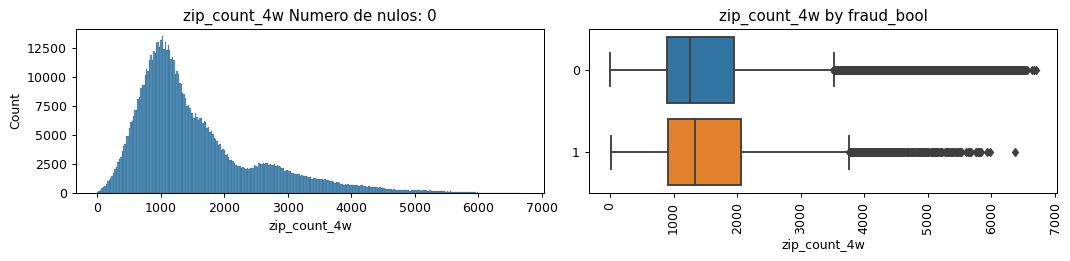

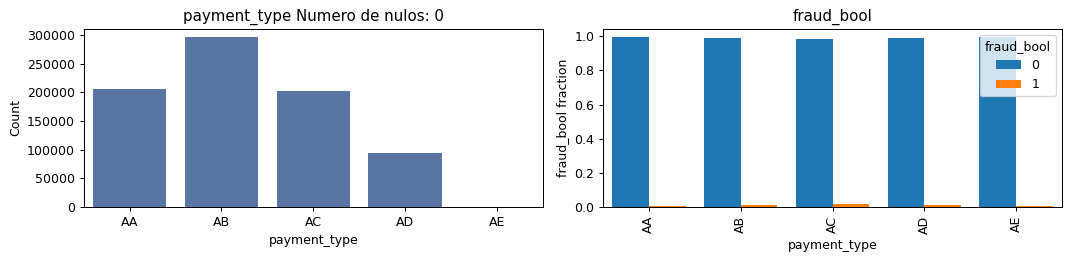

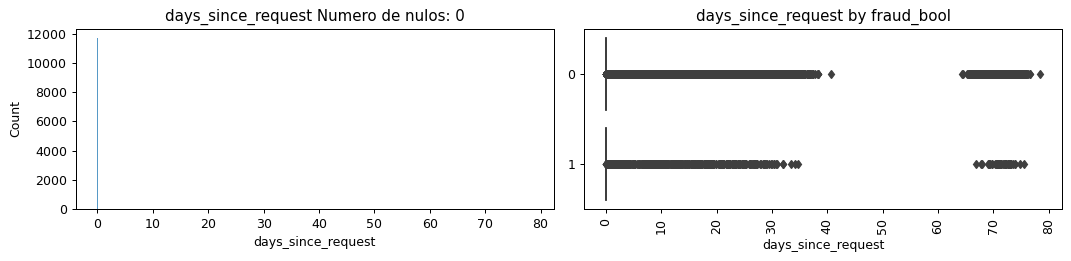

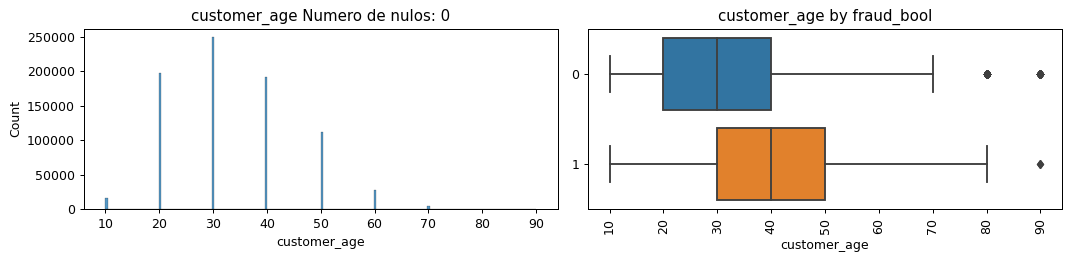

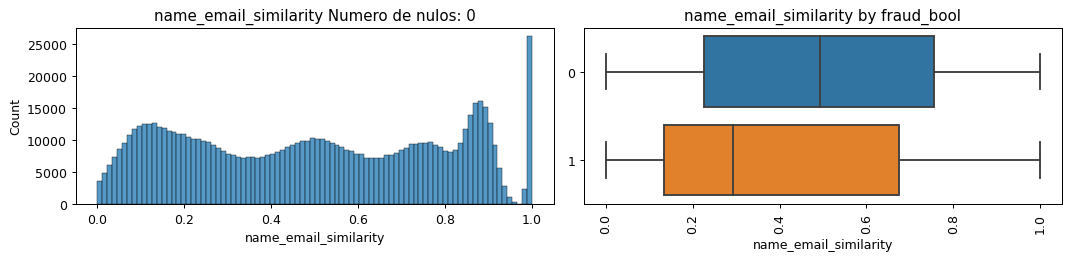

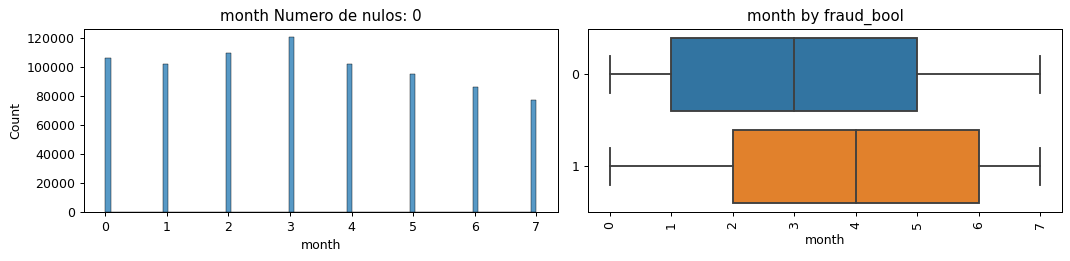

In [16]:
for i in list(df_fraud_train.columns[16:]):
    if (df_fraud_train[i].dtype == float) & (i != "fraud_bool"):
        f_aux.plot_feature(df_fraud_train, col_name = i, isContinuous = True, target = "fraud_bool")
    elif  i != "fraud_bool":
        f_aux.plot_feature(df_fraud_train, col_name = i, isContinuous = False, target = "fraud_bool")

Income- Se comete mayor fraude en los casos donde la variable income es más alta.
Name email similarity-la mayoria de la gente suelen poner su nombre en la direccion del email.
Customer age-suele cometer fraude con una edad comprendida entre los 30 y 50, siendo lo mas colun 40 años.
Payment type- Más común el tipo AB, siendo AC ligeramente utilizado más para aplicaciones fraudulentas.
-La otras demás variables no experimentan grandes patrones ni muchas diferencias que comentar.

### Tratamiento de las variables continuas:

In [31]:
# Visualización de la lista de variables numéricas:
continuous_list

['intended_balcon_amount',
 'prev_address_months_count',
 'bank_months_count',
 'current_address_months_count',
 'session_length_in_minutes',
 'device_distinct_emails_8w',
 'foreign_request',
 'phone_mobile_valid',
 'has_other_cards',
 'proposed_credit_limit',
 'keep_alive_session',
 'phone_home_valid',
 'credit_risk_score',
 'email_is_free',
 'income',
 'date_of_birth_distinct_emails_4w',
 'bank_branch_count_8w',
 'velocity_4w',
 'velocity_24h',
 'velocity_6h',
 'zip_count_4w',
 'days_since_request',
 'customer_age',
 'name_email_similarity',
 'month']

### Tratamiento de outliers:

In [32]:
# Visualizando todos los outliers de todas las variables:
f_aux.get_deviation_of_mean_perc(df_fraud_train, continuous_list, target = "fraud_bool", multiplier = 3)

,no_fraud,fraud,variable,sum_outlier_values,porcentaje_sum_outlier_values
0,0.990566,0.009434,intended_balcon_amount,1590,0.001988
1,0.992623,0.007377,prev_address_months_count,6913,0.008641
2,0.983881,0.016119,current_address_months_count,16937,0.021171
3,0.979659,0.020341,session_length_in_minutes,18829,0.023536
4,0.962539,0.037461,device_distinct_emails_8w,25146,0.031433
5,0.977982,0.022018,foreign_request,20211,0.025264
6,0.868181,0.131819,proposed_credit_limit,4931,0.006164
7,0.970022,0.029978,credit_risk_score,2702,0.003377
8,0.994610,0.005390,date_of_birth_distinct_emails_4w,5009,0.006261
9,0.989628,0.010372,bank_branch_count_8w,32779,0.040974


En la tabla de arriba podemos ver todos los outliers de todas las columnas numéricas del conjunto de datos. El dataset en su totalidad tiene un porcentaje de fraude de solo 2% y 98% de no tener fraude. Teniendo esto en cuenta, tiene sentido que la mayoria de los outliers tengan un porcentaje de fraude y no fraude parecido al de 2% y 98% respectivamente, pero podemos ver que esto no es lo que se observa en la variable de "proposed_credit_limit" donde cuentas bancarias que han cometido fraude son el 13% de los outliers. Por esta razón habría que revisar los outliers de esta variable más detenidamente ya que se excede de lo normal.

En general, ninguna variable tiene una cantidad de outliers que sea fuera de lo normal por lo que no van a influir significativamente en el resultado final del modelo predictivo de este análisis de fraude.

## Correlaciones:

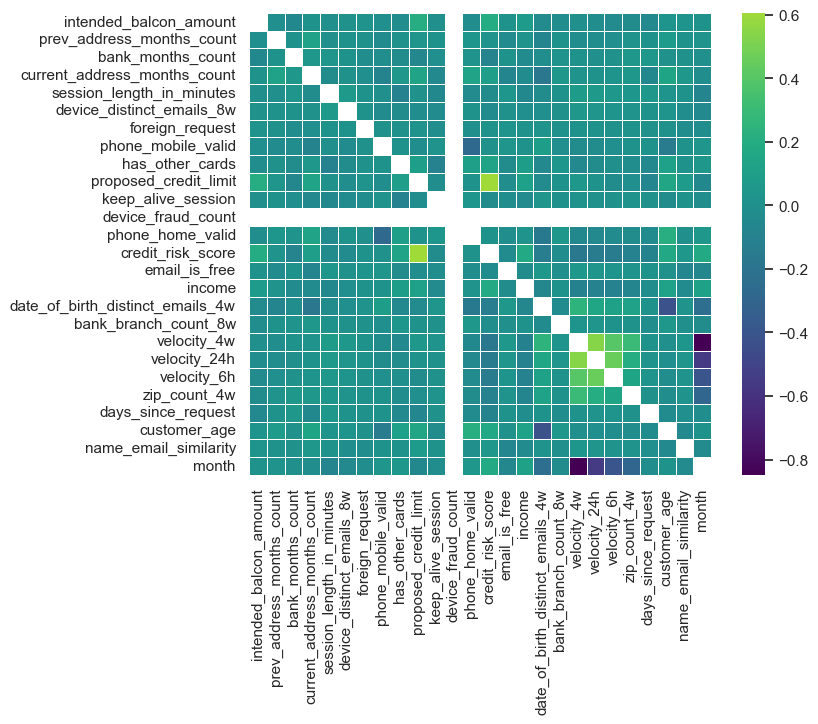

0

In [29]:
# Correlaciones entre las diferentes variables:
f_aux.get_corr_matrix(dataset = df_fraud_train[continuous_list], metodo = 'pearson', size_figure = [8,6])

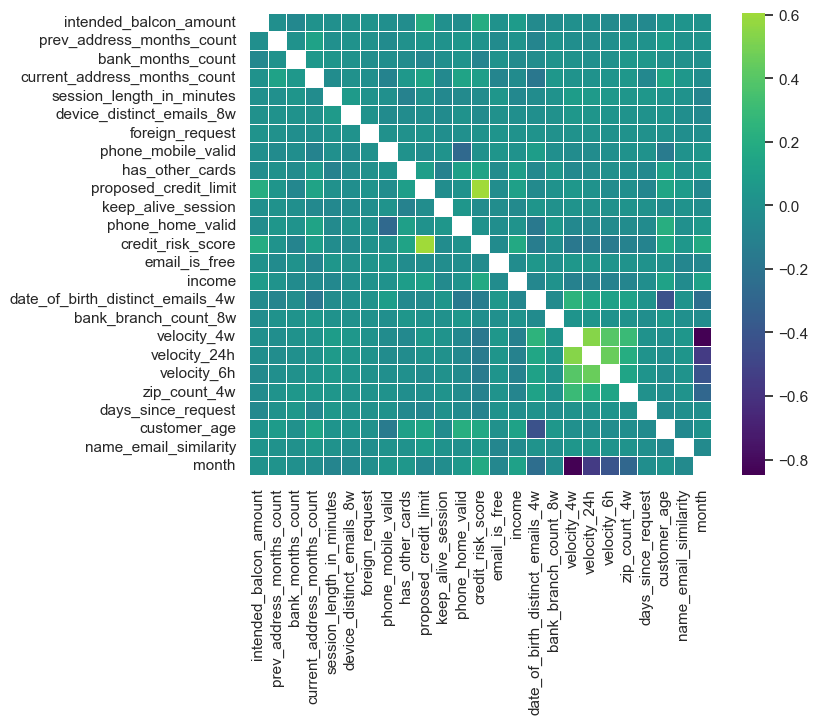

0

In [30]:
# Hemos visto que la variable de "device_fraud_count" tiene solo valores igual a "0", por lo que no es una variable 
# importante para el análisis de este proyecto ya que no contribuye información relevante. Además, aunque la eliminación de
# variables sea solo en la sección de selección de variables del notebook número tres, hemos eliminado esta variable en 
# específico para ilustra el gráfico de arriba con más claridad a continuación:

continuous_list.remove('device_fraud_count')

f_aux.get_corr_matrix(dataset = df_fraud_train[continuous_list], metodo = 'pearson', size_figure = [8,6])

In [33]:
# Visualizando las correlaciones entre las variables en una tabla para poder emfatizar las variables con más correlación:

corr = df_fraud_train[continuous_list].corr('pearson')
new_corr = corr.abs()
new_corr.loc[:,:] = np.tril(new_corr, k = -1) # below main lower triangle of an array
new_corr = new_corr.stack().to_frame('correlation').reset_index().sort_values(by='correlation', ascending=False)
new_corr[new_corr['correlation'] > 0.4]

,level_0,level_1,correlation
617,month,velocity_4w,0.848426
309,credit_risk_score,proposed_credit_limit,0.605965
618,month,velocity_24h,0.549936
467,velocity_24h,velocity_4w,0.538953
493,velocity_6h,velocity_24h,0.463183
565,customer_age,date_of_birth_distinct_emails_4w,0.420395
619,month,velocity_6h,0.409105
492,velocity_6h,velocity_4w,0.400367


### Tratamiento de valores nulos:

¿Son todos los nulos de una clase de la variable objetivo? o tienen el mismo porcentaje de la variable objetivo?

In [75]:
# df_fraud_train["intended_balcon_amount"].sort_index(ascending = True)

In [76]:
continuous_list

['intended_balcon_amount',
 'prev_address_months_count',
 'bank_months_count',
 'current_address_months_count',
 'session_length_in_minutes',
 'device_distinct_emails_8w',
 'foreign_request',
 'phone_mobile_valid',
 'has_other_cards',
 'proposed_credit_limit',
 'keep_alive_session',
 'phone_home_valid',
 'credit_risk_score',
 'email_is_free',
 'income',
 'date_of_birth_distinct_emails_4w',
 'bank_branch_count_8w',
 'velocity_4w',
 'velocity_24h',
 'velocity_6h',
 'zip_count_4w',
 'days_since_request',
 'customer_age',
 'name_email_similarity',
 'month']

In [77]:
f_aux.get_percent_null_values_target(df_fraud_train, continuous_list, target = "fraud_bool")

,sum_null_values,no_fraud,fraud,variable,porcentaje_sum_null_values
0,594088,0.986834,0.013166,intended_balcon_amount,0.742610
1,570356,0.985779,0.014221,prev_address_months_count,0.712945
2,202873,0.983729,0.016271,bank_months_count,0.253591
3,3398,0.997940,0.002060,current_address_months_count,0.004248
4,1601,0.991880,0.008120,session_length_in_minutes,0.002001
5,282,0.992908,0.007092,device_distinct_emails_8w,0.000353


De la tabla de arriba podemos ver las variables que tienen valores nulos, cuantos valores nulos tiene cada variable, y la proporción de nulos que son fraude o no fraude. De las 32 variables del conjunto de datos de fraude, solo hay seis variables que tengan valores nulos, de los cuales tres solo tiene menos de 1%. Por lo tanto, estas tres variables, las variables de "current_address_months_count", "session_length_in_minutes" y "device_distinct_emails_8w" tienen una cantidad de valores nulos insignificativa. Esto contrasta con las otras tres variables, las variables de "intended_balcon_amount", "prev_address_months_count" y "bank_months_count", que tienen una cantidad de valores nulos más significativa, especialmente las variables de "intended_balcon_amount" y "prev_address_months_count" ya que más del 70% de sus valores son nulos. 

Habiendo visto toda esta información, como no se pueden usar valores nulos en modelos que predigan fraude, es importante también mencionar los siguientes pasos que se pueden hacer para evitar valores nulos en el modelo final. Una opción sería eliminar todas las instancias que contengan un valor nulo en cualquier variable, el problema con esta opción es que demasiadas instancias serían eliminadas, por lo tanto, hemos decidido no usar este método. Otra opción sería reemplazar todos los valores nulos la media de la variable a la q pertenezcan, el problema con este método es que afectaría la precisión de los resultados de una manera negativa cuando la proporción de nulos en una variable es muy alta. Por lo tanto, este método funcionaría muy bien para las cuatro columnas con menos de 26% de nulos (siendo un método de coste computacional bajo) pero no funcionaría tan bien para las otras dos variables con proporciones más altas de nulos. Para estas dos últimas variables, lo ideal sería usar una regresión lineal de KNN que reemplace los nulos con valores que más tengan que ver con otras instancias similares del conjunto de datos.

El problema que existe con este último método de regresión lineal de KNN es que requiere un coste computacional mucho más alto que simplemente reemplazando la cantidad de nulos por la media de cada variable. Por esta razón, como reemplazar los nulos de las variables de "intended_balcon_amount" y "prev_address_months_count" tampoco sería demasiado impreciso, al final decidimos reemplazar todos los nulos de todas las variables con la media de cada variable.

Es importante mencionar que este proceso de reemplazamiento de nulos no se ha hecho en este notebook de EDA ya que se ha hecho en la parte de feature engineering del notebook núero tres de este análisis de fraude.

## Tratamiento de las variables categoricas:

Para la correlacion de spearman es necesario convertir las variables categoricas en numericas y luego obtener la correlación

In [78]:
categoricals_list

['fraud_bool',
 'device_os',
 'source',
 'housing_status',
 'employment_status',
 'payment_type']

In [79]:
confusion_matrix = pd.crosstab(df_fraud_train["fraud_bool"], df_fraud_train["device_os"])
print(confusion_matrix)
cramers_v(confusion_matrix.values)

device_os    linux  macintosh   other  windows   x11
fraud_bool                                          
0           264689      42602  272405   205760  5721
1             1392        607    1553     5208    63


0.0804786595855569

In [80]:
confusion_matrix = pd.crosstab(df_fraud_train["fraud_bool"], df_fraud_train["fraud_bool"])
print(confusion_matrix)
cramers_v(confusion_matrix.values)

fraud_bool       0     1
fraud_bool              
0           791177     0
1                0  8823


0.9999426978916621

In [81]:
confusion_matrix = pd.crosstab(df_fraud_train["fraud_bool"], df_fraud_train["source"])
print(confusion_matrix)
cramers_v(confusion_matrix.values)

source      INTERNET  TELEAPP
fraud_bool                   
0             785671     5506
1               8729       94


0.0044171336973312224

In [82]:
categoricals_list

['fraud_bool',
 'device_os',
 'source',
 'housing_status',
 'employment_status',
 'payment_type']

In [83]:
df_fraud["payment_type"].unique()

['AA', 'AB', 'AC', 'AD', 'AE']
Categories (5, object): ['AA', 'AB', 'AC', 'AD', 'AE']

In [84]:
device_map = {'windows': 1, 'other': 2, 'linux': 3, 'macintosh': 4, "x11": 5}
source_map = {"INTERNET": 1, "TELEAPP": 2}
housing_map = {'BA': 1, 'BB': 2, 'BC': 3, 'BD': 4, "BE": 5, 'BF': 6, 'BG': 7}
employment_map = {'CA': 1, 'CB': 2, 'CC': 3, 'CD': 4, "CE": 5, 'CF': 6, 'CG': 7}
payment_map = {'AA': 1, 'AB': 2, 'AC': 3, 'AD': 4, "AE": 5, 'AF': 6, 'AG': 7}

df_fraud['device_os'] = df_fraud['device_os'].map(device_map).astype("float64")
df_fraud['source'] = df_fraud['source'].map(source_map).astype("float64")
df_fraud['housing_status'] = df_fraud['housing_status'].map(housing_map).astype("float64")
df_fraud['employment_status'] = df_fraud['employment_status'].map(employment_map).astype("float64")
df_fraud['payment_type'] = df_fraud['payment_type'].map(payment_map).astype("float64")

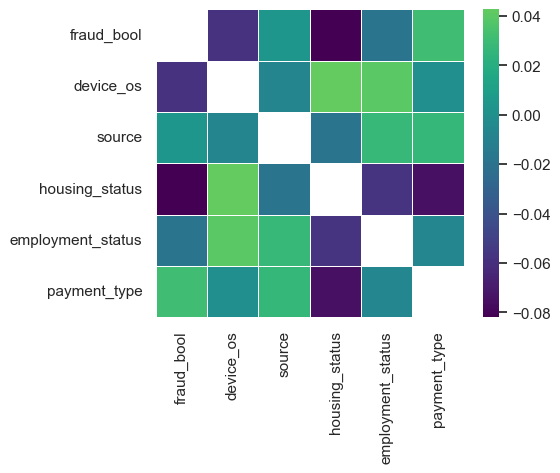

0

In [85]:
f_aux.get_corr_matrix(dataset = df_fraud[categoricals_list], metodo = 'spearman', size_figure=[5,4])

Destaca:

La correlación positiva entre "fraud_bool" y "payment_type" indica que hay una asociación entre el tipo de pago utilizado y la ocurrencia de fraudes. Es decir, ciertos tipos de pago pueden estar más relacionados con aplicaciones fraudulentas que otros. Esta relación puede ser útil para identificar patrones de comportamiento fraudulento en transacciones financieras.

La correlación entre "employment_status" y "device" sugiere que existe una relación entre el estado laboral del solicitante y el dispositivo desde el cual se realiza la aplicación. Podría interpretarse que ciertos estados laborales están más asociados con ciertos dispositivos, lo que podría ser útil para comprender el comportamiento de solicitud en función de la situación laboral.

La correlación entre "device_os" y "housing_status" indica una relación entre el sistema operativo del dispositivo utilizado y el estado de la vivienda del solicitante. Esta relación puede proporcionar información sobre las preferencias de uso de dispositivos en diferentes contextos de vivienda. Por ejemplo, ciertos sistemas operativos pueden ser más comunes en entornos de vivienda específicos.



### Tratamiento de valores nulos:

No hay valores nulos en las variables categoricas de este conjunto de datos, pero si hubiera hariamos lo siguiente:

In [86]:
df_fraud_train[categoricals_list] = df_fraud_train[categoricals_list].astype("object")\
.fillna("SIN VALOR").astype("category")

df_fraud_test[categoricals_list] = df_fraud_test[categoricals_list].astype("object").\
fillna("SIN VALOR").astype("category")

### Guardando las tablas de train y test:

In [34]:
# Guardamos los datos para procesarlos en el siguiente notebook, una vez acabado el EDA.
df_fraud.to_csv("../data/df_data_preprocessing_missing_and_outliers.csv")